# Chapter 06. Model Monitoring

## 6.1. Enable Data Capture for a Model Endpoint
---

In [ ]:
%cd /root/sagemaker-course/notebooks/

In [3]:
import time

import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role, model

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 70)

# S3 bucket information
BUCKET = 'sagemaker-course-20200517'
PREFIX = 'churn'
LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'
print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

# Session variables we'll use throughout the notebook
sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session
sagemaker_client = boto_session.client('sagemaker')
role = get_execution_role()
print(f'Role ARN: {role}')

Artifacts will be written to s3://sagemaker-course-20200517/churn
Role ARN: arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200414T065516


In [4]:
model_data = 's3://sagemaker-course-20200517/churn/builtin-xgboost-2020-05-17-13-59-20-155/output/model.tar.gz'
image = '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

churn_model = model.Model(model_data=model_data,
                          image=image,
                          role=role,
                          sagemaker_session=sagemaker_session)

In [5]:
from sagemaker import model_monitor, predictor

In [7]:
captured_data_s3_uri = f's3://{BUCKET}/{PREFIX}/model-monitor/data-capture'
print(f'Captured data stored in bucket: {captured_data_s3_uri}')

data_capture_config = model_monitor.DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=captured_data_s3_uri,
    sagemaker_session=sagemaker_session)

Captured data stored in bucket: s3://sagemaker-course-20200517/churn/model-monitor/data-capture


In [12]:
churn_model.deploy(initial_instance_count=1, 
                   instance_type='ml.t2.medium',
                   data_capture_config=data_capture_config)

---------------!

In [13]:
print(churn_model.name)
print(churn_model.endpoint_name)

sagemaker-xgboost-2020-05-20-13-56-05-744
sagemaker-xgboost-2020-05-20-13-56-05-744


In [18]:
churn_predictor = predictor.RealTimePredictor(
    endpoint=churn_model.endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer = predictor.csv_serializer,
    content_type='text/csv')

In [11]:
!head -3 ../data/churn/test_sample.csv

186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55
132,25,113.2,96,269.9,107,229.1,87,7.1,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
112,17,183.2,95,252.8,125,156.7,95,9.7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


In [24]:
print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(churn_model.endpoint_name))

with open(f'{LOCAL_DATA_DIRECTORY}/test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = churn_predictor.predict(data=payload)
        time.sleep(0.5)

Sending test traffic to the endpoint sagemaker-xgboost-2020-05-20-13-56-05-744. 
Please wait for a minute...


The format of the Amazon S3 path is:

```
s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl
```

In [17]:
import json
from sagemaker.s3 import S3Uploader, S3Downloader

In [27]:
current_endpoint_capture_prefix = f'{PREFIX}/model-monitor/data-capture/{churn_model.endpoint_name}'
capture_files = S3Downloader.list(f"s3://{BUCKET}/{current_endpoint_capture_prefix}")

print("Found Data Capture Files:")
print(capture_files)

Found Data Capture Files:
['s3://sagemaker-course-20200517/churn/model-monitor/data-capture/sagemaker-xgboost-2020-05-20-13-56-05-744/AllTraffic/2020/05/20/14/08-54-910-b987f99d-76be-4298-b9ba-cc6fd5a950c5.jsonl']


In [32]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:2000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.014719205908477306",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "f38dfc73-c631-4396-bffc-3313a7157be7",
    "inferenceTime": "2020-05-20T14:08:54Z"
  },
  "eventVersion": "0"
}


In [14]:
!head -1 ../data/churn/test_sample.csv

186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55


## 6.1 Generate Feature Constraints and Suggestions with a Baseline Dataset

In [19]:
baseline_prefix = f'{PREFIX}/baselining'
baseline_data_prefix = f'{baseline_prefix}/data'
baseline_results_prefix = f'{baseline_prefix}/results'

# Store the training data
baseline_data_uri = f's3://{BUCKET}/{baseline_data_prefix}'
# Store the results of our baseline job
baseline_results_uri = f's3://{BUCKET}/{baseline_results_prefix}'

print(f'Baseline data URI: {baseline_data_uri}')
print(f'Baseline results URI: {baseline_results_uri}')

baseline_data_path = S3Uploader.upload(
    f"{LOCAL_DATA_DIRECTORY}/training-dataset-with-header.csv",
    baseline_data_uri)

Baseline data URI: s3://sagemaker-course-20200517/churn/baselining/data
Baseline results URI: s3://sagemaker-course-20200517/churn/baselining/results


In [ ]:
my_default_monitor = model_monitor.DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_path,
    dataset_format=model_monitor.DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True)

In [22]:
S3Downloader.list(f's3://{BUCKET}/{baseline_results_prefix}')

['s3://sagemaker-course-20200517/churn/baselining/results/constraints.json',
 's3://sagemaker-course-20200517/churn/baselining/results/statistics.json']

In [38]:
constraints_df = pd.json_normalize(my_default_monitor.suggested_constraints().body_dict["features"])
constraints_df.head(5)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True


The `statistics.json` file contains statistical information about the data in the baseline. We can view these constraints by calling the `baseline_statistics` method.

In [39]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.json_normalize(my_default_monitor.baseline_statistics().body_dict["features"])
schema_df.head(5)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'co...",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70...."
2,VMail Message,Integral,2333,0,8.214316,19164.0,13.776908,0.0,51.0,"[{'lower_bound': 0.0, 'upper_bound': 5.1, 'cou...",0.64,2048.0,"[[19.0, 0.0, 0.0, 40.0, 36.0, 0.0, 0.0, 24.0, ..."
3,Day Mins,Fractional,2333,0,180.226489,420468.4,53.987179,0.0,350.8,"[{'lower_bound': 0.0, 'upper_bound': 35.08, 'c...",0.64,2048.0,"[[178.1, 160.3, 197.1, 105.2, 283.1, 113.6, 23..."
4,Day Calls,Integral,2333,0,100.259323,233905.0,20.165008,0.0,165.0,"[{'lower_bound': 0.0, 'upper_bound': 16.5, 'co...",0.64,2048.0,"[[110.0, 138.0, 117.0, 61.0, 112.0, 87.0, 122...."


## 6.3 Creating a Monitoring Schedule
---

In [40]:
from time import gmtime, strftime

reports_prefix = f'{PREFIX}/reports'
s3_report_path = f's3://{BUCKET}/{reports_prefix}'

mon_schedule_name = 'xgb-churn-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

my_default_monitor.create_monitoring_schedule(
    endpoint_input=churn_predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    monitor_schedule_name=mon_schedule_name,
    schedule_cron_expression=model_monitor.CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True)


Creating Monitoring Schedule with name: xgb-churn-model-schedule-2020-05-20-14-30-19


In [44]:
from threading import Thread
from time import sleep
import time

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                                      ContentType='text/csv', 
                                                      Body=payload)
            time.sleep(10)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(churn_model.endpoint_name, f'{LOCAL_DATA_DIRECTORY}/test-dataset-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

In [ ]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...\n\n")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()

## 6.4 Visualizing Drift
---

In [ ]:
latest_execution = mon_executions[-1]
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))

In [50]:
print("Found Report Files:")
report_uri = latest_execution.output.destination
S3Downloader.list(report_uri)

Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.
Found Report Files:


['s3://sagemaker-course-20200517/churn/reports/sagemaker-xgboost-2020-05-20-13-56-05-744/xgb-churn-model-schedule-2020-05-20-14-30-19/2020/05/20/15/constraint_violations.json',
 's3://sagemaker-course-20200517/churn/reports/sagemaker-xgboost-2020-05-20-13-56-05-744/xgb-churn-model-schedule-2020-05-20-14-30-19/2020/05/20/15/constraints.json',
 's3://sagemaker-course-20200517/churn/reports/sagemaker-xgboost-2020-05-20-13-56-05-744/xgb-churn-model-schedule-2020-05-20-14-30-19/2020/05/20/15/statistics.json']

In [56]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
constraints_df = pd.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

,feature_name,constraint_check_type,description
0,State_OR,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
1,State_WV,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
2,State_UT,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
3,State_SC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
4,State_MA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
5,State_HI,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
6,State_AK,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
7,State_WY,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
8,State_TN,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."
9,State_MO,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.30555555555556% of data is Integral."


In [ ]:
latest_monitoring_violations = my_default_monitor.latest_monitoring_constraint_violations()
latest_monitoring_statistics = my_default_monitor.latest_monitoring_statistics()

## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [57]:
processing_job_arn = latest_execution.describe()['ProcessingJobArn']
processing_job_arn

'arn:aws:sagemaker:us-east-2:209970524256:processing-job/model-monitoring-202005201500-ffe84e378cf97a6a63f43ee1'

In [58]:
import os

from sagemaker.model_monitor import MonitoringExecution

In [59]:
execution = MonitoringExecution.from_processing_arn(
    sagemaker_session=sagemaker_session,
    processing_job_arn=processing_job_arn)

exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [60]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

In [62]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

--2020-05-20 16:05:18--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12655 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  12.36K  --.-KB/s    in 0s      

2020-05-20 16:05:18 (121 MB/s) - ‘utils.py’ saved [12655/12655]



In [64]:
mu.show_violation_df(baseline_statistics=baseline_statistics,
                     latest_statistics=execution_statistics,
                     violations=violations)

,data_type,completeness,baseline_drift,categorical_values
Account Length,Integral,100.00%,N/A,N/A
Area Code_408,Fractional,100.00%,N/A,N/A
Area Code_415,Fractional,100.00%,N/A,N/A
Area Code_510,Fractional,100.00%,N/A,N/A
Churn,Fractional,100.00%,N/A,N/A
CustServ Calls,Integral,100.00%,N/A,N/A
Day Calls,Integral,100.00%,N/A,N/A
Day Mins,Fractional,100.00%,N/A,N/A
Eve Calls,Integral,100.00%,N/A,N/A
Eve Mins,Fractional,100.00%,N/A,N/A


In [65]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,288,0,0.121015,34.85218,0.246669,0.002989,0.993593
Account Length,288,0,99.760417,28731.00000,40.589513,10.000000,232.000000
VMail Message,288,0,6.702083,1930.20000,12.276850,0.000000,43.000000
Day Mins,288,0,178.247222,51335.20000,54.363873,46.500000,328.100000
Day Calls,288,0,101.177083,29139.00000,20.024461,36.000000,150.000000
Eve Mins,288,0,202.717014,58382.50000,47.252157,76.400000,323.200000
Eve Calls,288,0,101.125000,29124.00000,21.308050,36.000000,149.000000
Night Mins,288,0,207.264583,59692.20000,50.845662,63.600000,344.300000
Night Calls,288,0,98.680556,28420.00000,20.331507,33.000000,154.000000
Intl Mins,288,0,10.030556,2888.80000,2.646572,0.000000,18.300000


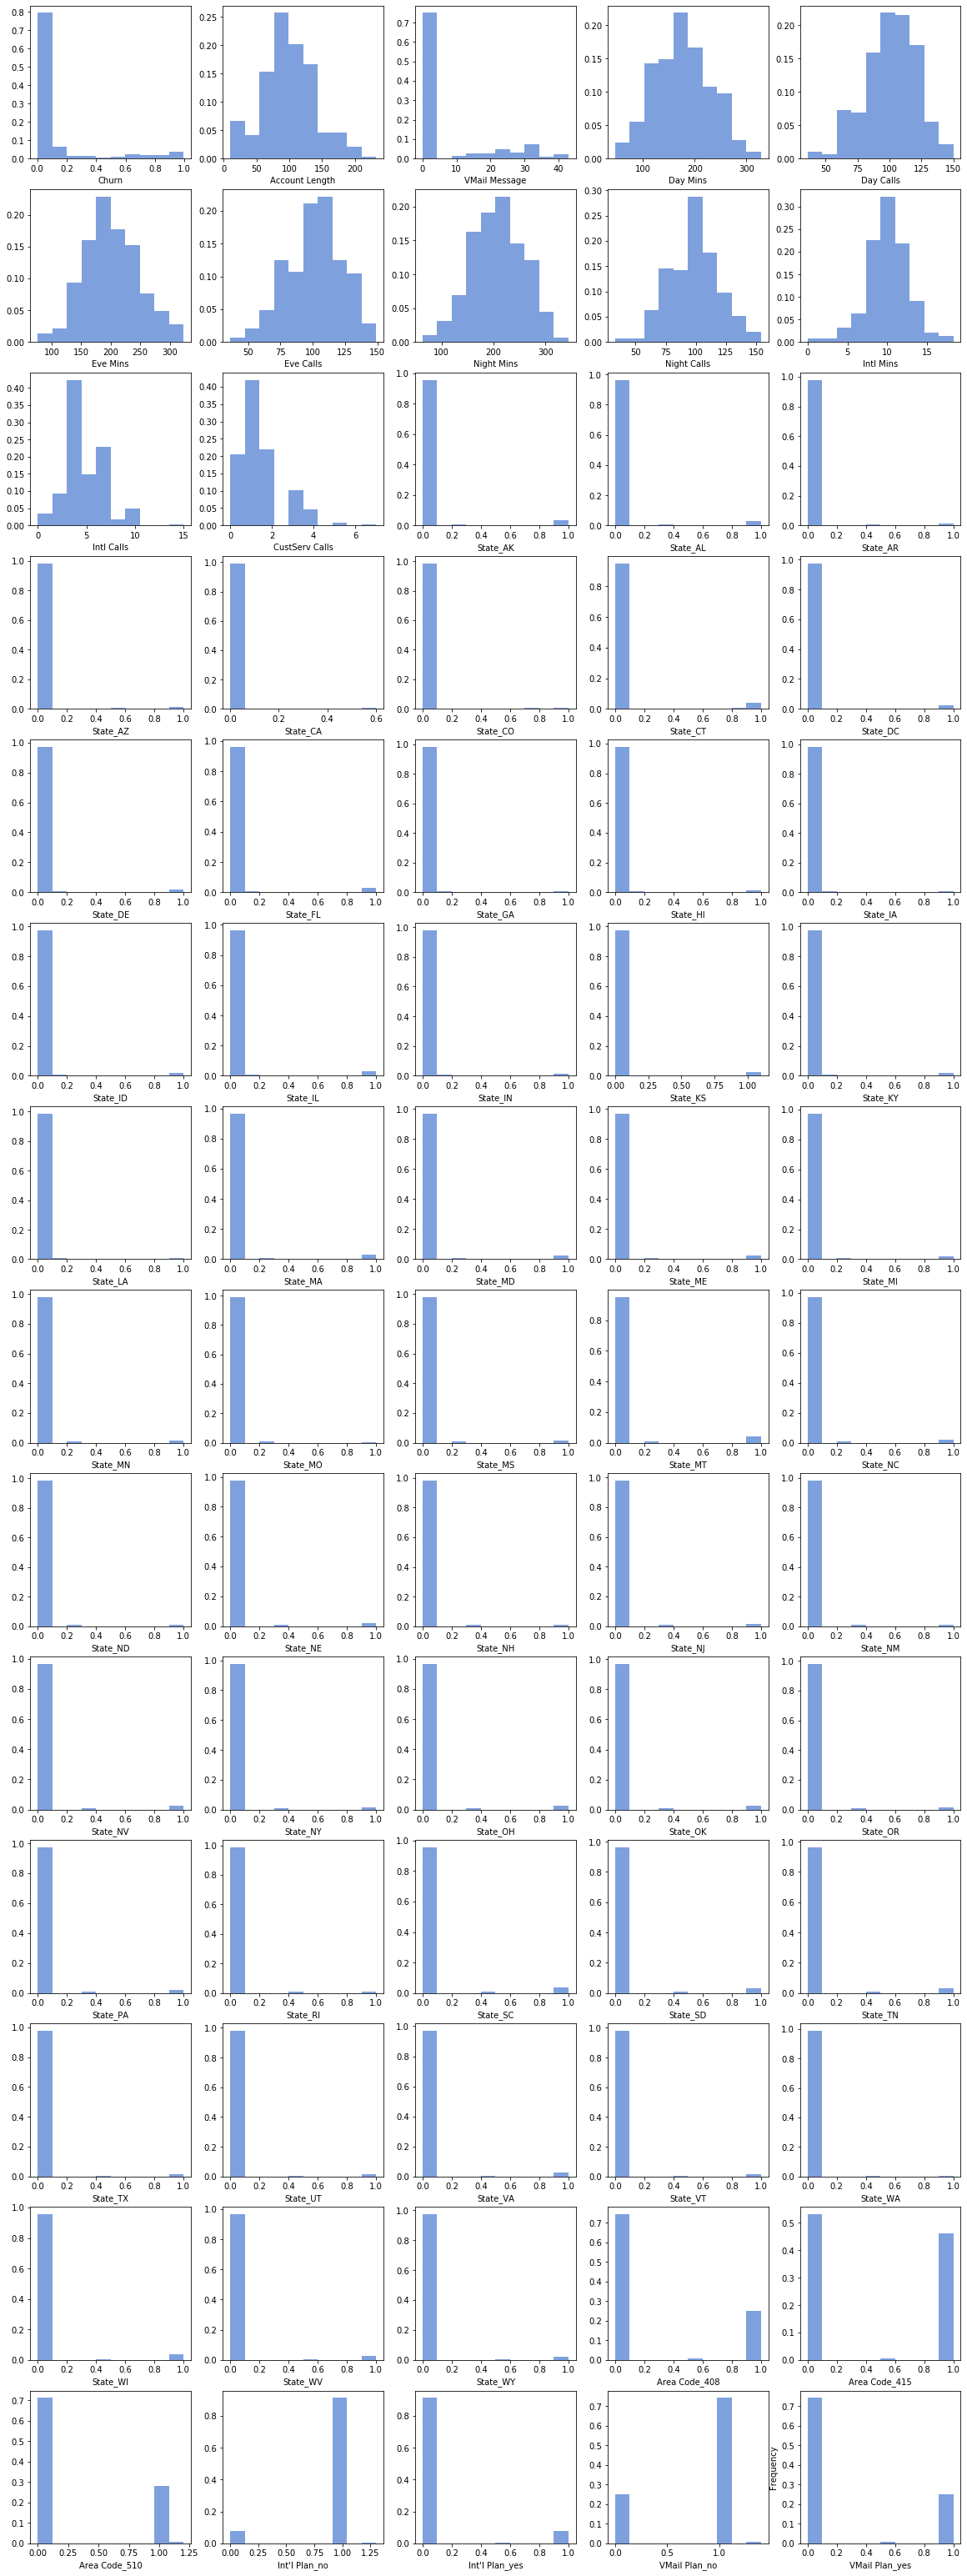

In [67]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,288,0,0.121015,34.85218,0.246669,0.002989,0.993593
Account Length,288,0,99.760417,28731.00000,40.589513,10.000000,232.000000
VMail Message,288,0,6.702083,1930.20000,12.276850,0.000000,43.000000
Day Mins,288,0,178.247222,51335.20000,54.363873,46.500000,328.100000
Day Calls,288,0,101.177083,29139.00000,20.024461,36.000000,150.000000
Eve Mins,288,0,202.717014,58382.50000,47.252157,76.400000,323.200000
Eve Calls,288,0,101.125000,29124.00000,21.308050,36.000000,149.000000
Night Mins,288,0,207.264583,59692.20000,50.845662,63.600000,344.300000
Night Calls,288,0,98.680556,28420.00000,20.331507,33.000000,154.000000
Intl Mins,288,0,10.030556,2888.80000,2.646572,0.000000,18.300000


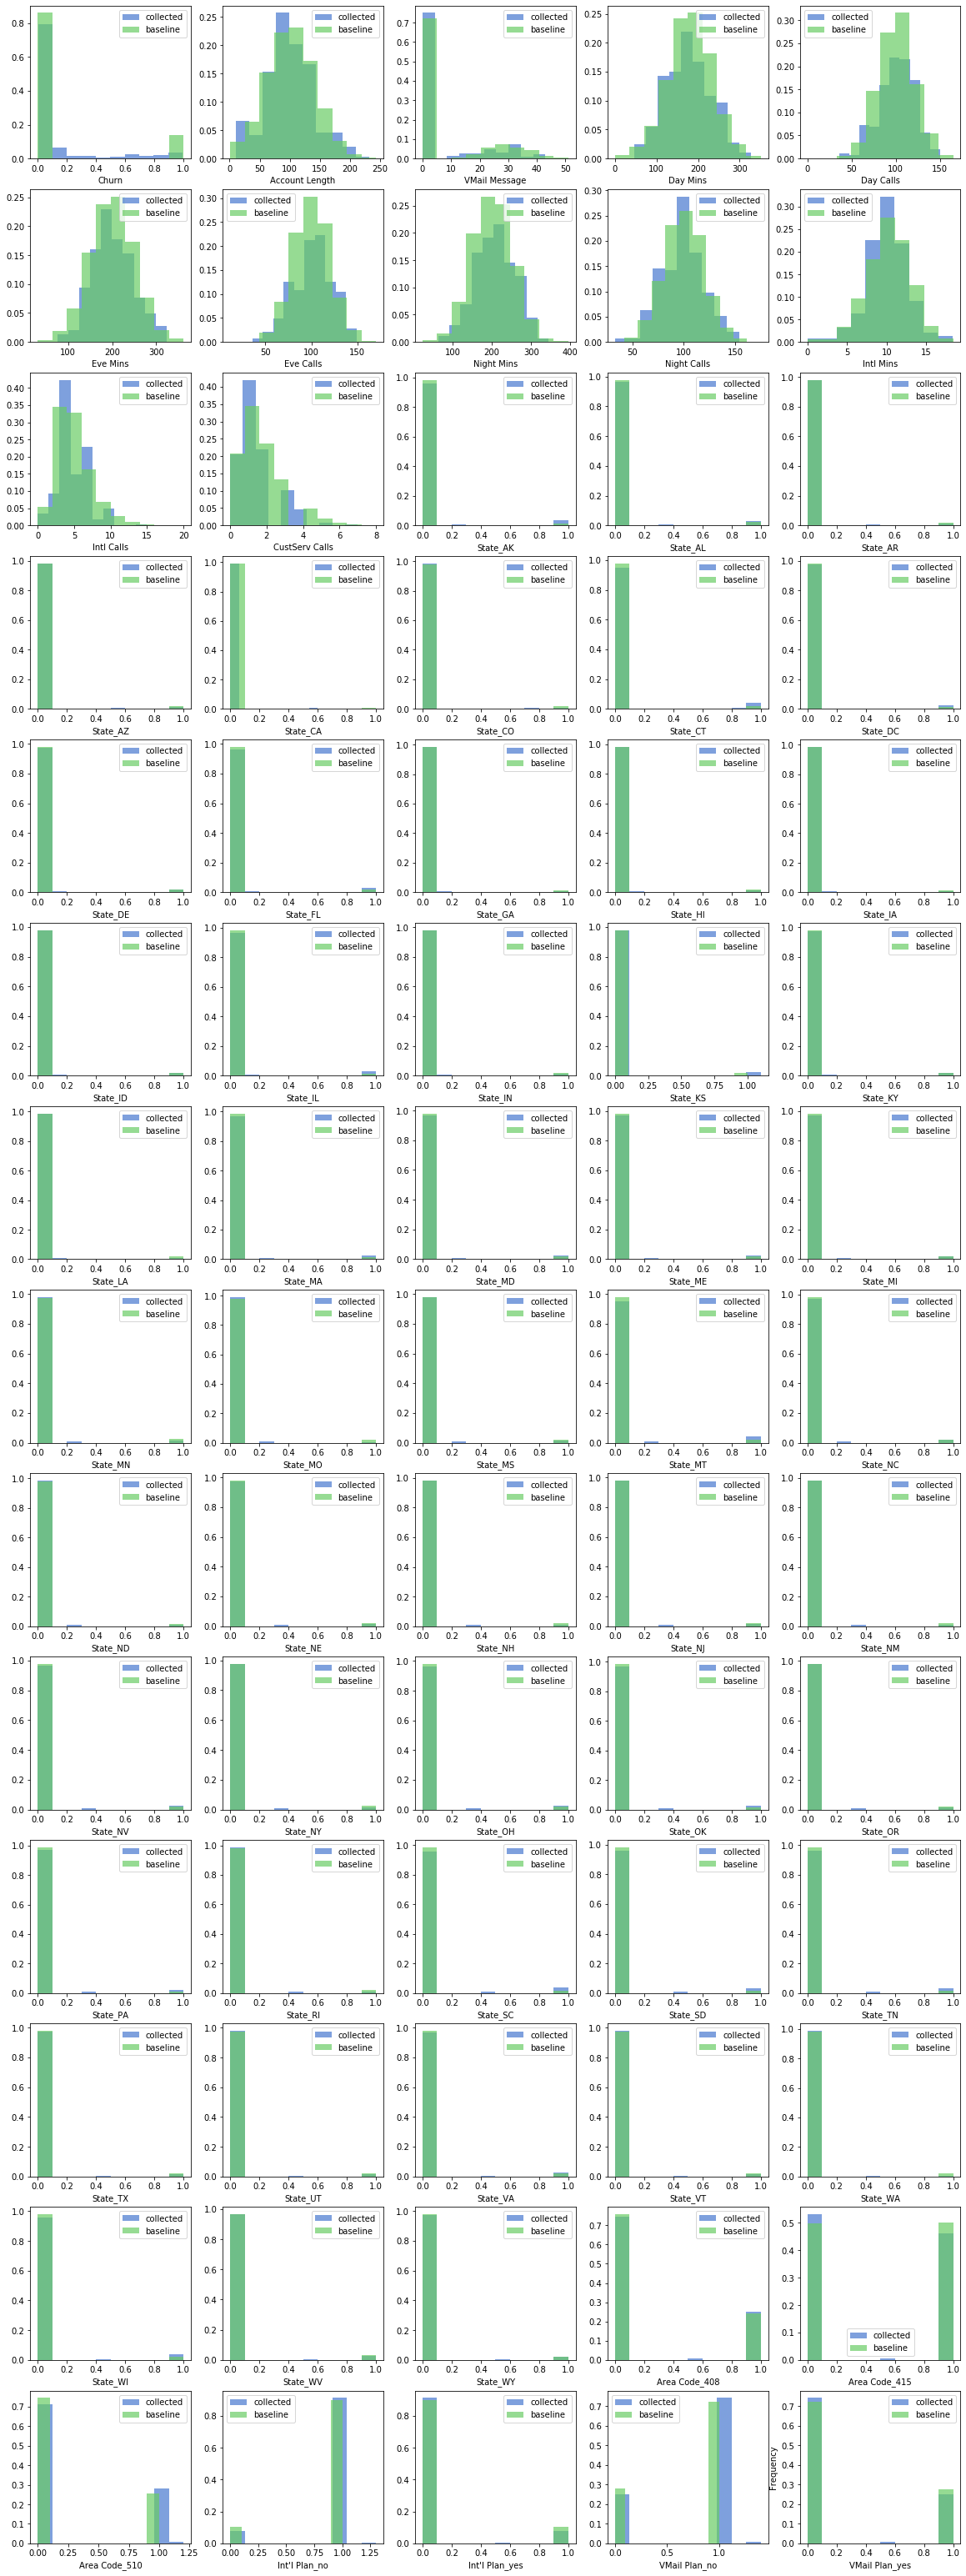

In [66]:
mu.show_distributions(features, feature_baselines)

In [ ]:
sagemaker_session.delete_monitoring_schedule(mon_schedule_name)
sagemaker_session.delete_endpoint(churn_model.endpoint_name)
sagemaker_session.delete_model(churn_model.name)